# Introduction on Statsmodels

This tutorial will introduce the basics of using statmodels, a Python module geared towards the entire pipeline of statistical analysis after data collection. Similar to R (in functionality and, occasionally, syntax), Statsmodels allows for users to quickly conduct exploratory data analysis, statistical models, perform hypothesis test, and build clean visualizations with minimal code.


## Tutorial Contents

In order to facilitate learning some basic functionalities, we will use a couple datasets from the Rdataset Repository as well as artificial datasets. The first one we will be looking at is called "Cars93", which takes a look at a sample of the cars on sale in the US in 1993.

We will cover these following topics:

1. [How to install Statsmodels](#How to install)
2. [Different methods of loading data](#Different methods of loading data)
3. [Exploratory Data Analysis and Diagnostic Checks](#EDA)
4. [Hypothesis Testing](#Hypothesis Testing)
5. [Dealing with multicolinearity](#Multicolinearity)
6. [Ordinary Least Squares versus Robust Linear Models (OLM vs RLM)](#RLM) 
7. [Multiple Linear Regression](#Multiple Linear Regression and ANOVA)
8. [Additional References](#Additional Resources)

We will assume that you have sufficient knowledge about statistical analysis. The main purpose of the tutorial is <b>not</b> to teach about probability theory, inference or regression, but <b>how to effectively use this module to conduct statistical analysis</b>. If you want to go into some of the theory, please visit Zico Kolter's 15-388 [website](http://www.datasciencecourse.org).


<a id='How to install'></a>
## How to install

Before we start doing analysis on the cars, we must download the Statsmodels module and its dependencies. We can install Statsmodel using setuptools:

```
easy_install -U statsmodels
```

That should be it! (Make sure you have installed Python 2.6 + ,numpy, scipy, pandas, and patsy if you are not using Jupyter).

Make sure the installation worked by running the following commands:

In [1]:
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

As a side note, we imported both `statsmodels.formula.api` and `statsmodels.api` because the former allow users the option to fit statistical models using R-style formulas. The latter is still necessary as not all functions at this time can be represented in such a way. In this tutorial, I will present the R-style formulas when possible to let readers know there are two options. However I will stick with the standard non-R way as the default.

<a id='Different methods of loading data'></a>
## Different Methods of Loading Data

It is possible to load in any local .csv file by using `read_csv` (make sure the file is in the same working directory!). There is however a Statsmodels function that allows us to directly download the specific dataset in the Rdatasets repository (returns a Dataset instance):

In [2]:
df_alt = pd.read_csv("co2.csv") #<-- if you want to load data locally
df = sm.datasets.get_rdataset("Cars93", "MASS").data
df.head()

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,...,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,Audi,100,Midsize,30.8,37.7,44.6,19,26,Driver & Passenger,Front,...,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


It is also possible to load in other common file types, such as .dta. More information about importing other types of data can be found [here](http://statsmodels.sourceforge.net/devel/iolib.html).

Before continuing on with the analysis, we should make sure there are no NA values in any cell:

In [3]:
print len(df) #before dropping rows with NA's
df = df.dropna()
print len(df)

93
82


<a id='EDA'></a>
## Exploratory Data Analysis and Diagonostic Checks

Let's say you want to see if there is a possible relationship between miles per gallon of a vehicle and the price of the vehicle. While an average price is already given, there is no column that gives us the average MPG. We can quickly create a new column:

In [4]:
df["MPGavg"]=(df["MPG.city"] + df["MPG.highway"])/2

Below is our first example of R-style code vs Non-R-style code. Notice that when we are fitting our regression model, the R-style code implicitly adds a column of 1's in the design matrix. If we are using the standard style, we have to explictly add that column in. By using `add_constant`, the column of ones is prepended. Regardless of which style you choose, it yields the same model.

In [5]:
#R-Style
results = smf.ols('Price ~ MPGavg', data=df).fit()
#print results.summary() 

#Non-R-Style
secDF = df.copy()
y=secDF["Price"]
x = secDF[["MPGavg"]]
x = sm.add_constant(x) #<-- adding column of one's into Design Matrix
mod = sm.OLS(y,x)
results2 = mod.fit()
print results2.summary()

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     53.29
Date:                Wed, 02 Nov 2016   Prob (F-statistic):           1.87e-10
Time:                        22:15:59   Log-Likelihood:                -283.40
No. Observations:                  82   AIC:                             570.8
Df Residuals:                      80   BIC:                             575.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.1189      4.460     11.463      0.0

We can extract specific information about our linear model.  `dir()` will list out all the possible quantities you can extract. Below are a few examples:

In [6]:
dir(results2)
print results2.params
print results2.rsquared
print results2.pvalues

const     51.118920
MPGavg    -1.204207
dtype: float64
0.399820946369
const     1.474607e-18
MPGavg    1.869453e-10
dtype: float64


Side note: *Hypothesis testing for ols in statsmodels will default to a Null Hypothesis of the parameters equaling 0.*

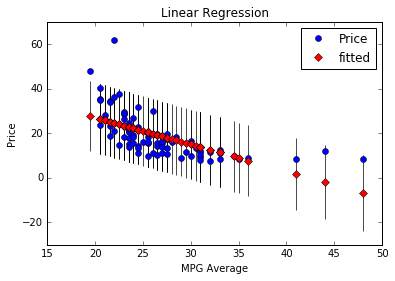

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(results2, -1, ax=ax)
ax.set_ylabel("Price")
ax.set_xlabel("MPG Average")
ax.set_title("Linear Regression")
plt.show()

Now that we have our model as well as a visual, we can run some diagonstic checks to see if a linear model makes sense in this case. Statsmodels has a multitude of diagonstic checks for linear regression (a link to other checks); I will introduce two fairly common ones below and two more advanced tests.

1) In statsmodels, we can plot a `qqplot` (Q-Q Plot) to check if errors are normally distributed. In our case, everything looks ok!

2) A neat and convienient function is `plot_regress_exog` which gives us 4 graphs: ‘response vs predictor’, ‘residuals vs predictor’, ‘fitted versus predictor’ and ‘fitted plus residual vs predictor’. In our case, we see patterns in the residuals; this indicates that our linear model may not be the best option.

3) Harvey Collier Test which also checks for linearity. In our case, the p-value is 0.48, reconfirming that a linear model is not appropriate.

4) Goldfeldquandt test checks for hetroskedasticity. In our case, the p-value is 0.13. Hetroskedasticity is apparent. 

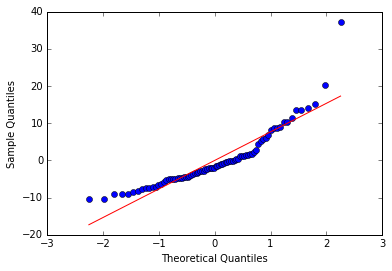

In [8]:
res = results2.resid # residuals
fig = sm.qqplot(res,line='s')

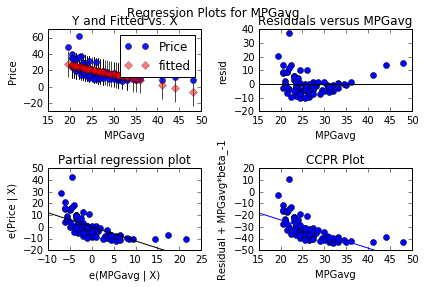

In [9]:
figs = sm.graphics.plot_regress_exog(results2, -1, fig=None)

In [10]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(results2)
print lzip(name, test)

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
print lzip(name, test)

[('t value', -0.70047765712859711), ('p value', 0.48571330203351837)]
[('F statistic', 1.4373795066504558), ('p-value', 0.13079787581171431)]


Since initial diagonistic tests all point to a linear model not being viable, conducting hypothesis tests and inference will be useless in this case. In the next section, we will dive deeper into hypothesis testing in StatsModels with a dataset that meets all asumptions.

<a id='Hypothesis Testing'></a>
## Hypothesis Testing - SLR

The next dataset we will be looking at is the relationship of height and weight of 15 women.

In [11]:
data = sm.datasets.get_rdataset("women", "datasets").data
results = smf.ols('weight ~ height', data=data).fit()
results.summary()

//anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1433.
Date:                Wed, 02 Nov 2016   Prob (F-statistic):           1.09e-14
Time:                        22:16:01   Log-Likelihood:                -26.541
No. Observations:                  15   AIC:                             57.08
Df Residuals:                      13   BIC:                             58.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -87.5167      5.937    -14.741      0.000    -100.343     -74.691
height         3.4500      0.091     37.855      0.000       3.253       3.647
==============================================================================
Omnibus:                        2.396   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.660
Skew:                           0.789   Prob(JB):                        0.436
Kurtosis:                       2.596   Cond. No.                         982.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary output above already gives us a slope of 3.45 (for every unit increase in height, there is a predicted 3.45 unit increase in weight). It also give us the p-value (0.000), as well as the confidence interval for the slope (3.253, 3.647). In this case, we reject the null hypothesis that there is no linear relationship as the p-value is less than any reasonable alpha level, and accept that there is a relationship.

But what if we want to test some other hypothesis? Let's say we want to test if the slope estimator is in fact 5 (we believe that, for some reason, one unit increase of height leads to 5 unit increase in weight). How can we do that in Statsmodels?

In [12]:
# Testing 1: 
#Null Hyp: Height = 5
#Alt Hyp: Height != 5

hypotheses = 'height = 5'
t_test = results.t_test(hypotheses)
print t_test

#Testing 2:
#Null Hyp: Height = 3.3
#Alt Hyp: Height != 3.3
hypotheses_2 = 'height = 3.3'
t_test = results.t_test(hypotheses_2)
print t_test

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             3.4500      0.091    -17.007      0.000       3.253       3.647
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             3.4500      0.091      1.646      0.124       3.253       3.647


While there are many ways to go about this, a simple and intuitive way to conduct hypothesis testing is to feed the `t_test` function a string, where Statsmodel will parse the string and interpret which estimator you are conducting and at what value. Above, we test if the slope is 5 or not and if the slope is 3.3 or not, respectively. Not surprisingly, they are are consistent with the default test the summary output gives: any test outside of (3.253, 3.647) will result in rejection and any test inside of (3.253, 3.647) will result in fail to reject.

This is a very basic example of hypothesis testing for one predictor variable. This method can be extended to multivariate regression, where instead of a t-test, an F-test would be utilized to check if at least one estimator is statistically significant from 0. An example of such a case can be found [here](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLSResults.f_test.html#statsmodels.regression.linear_model.OLSResults.f_test). Below, we will perform F-test manually on birthweight data.

<a id='Multicolinearity'></a>
## Dealing with Multicolinearity in StatsModel

As a refresher, multicolinearity is when 2 (or more) exogenous variables are highly corrlelated to each other. While we do not want high Multicolinearity, we definitely do not want Perfect Multicolinearity. We return back to the cars data but we add a column where we convert miles/gallon to km/gallon. This should result in perfect multicolinearity as one column is just a multiple of another.

In [13]:
df["kmPGavg"] = df["MPGavg"] * 1.6
#print df

thirdDF = df.copy()
y = thirdDF["Price"]
x = thirdDF[["MPGavg","kmPGavg"]]
x = sm.add_constant(x) #<-- adding column of one's into Design Matrix
mod = sm.OLS(y,x)
results2 = mod.fit()
print results2.summary()


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     53.29
Date:                Wed, 02 Nov 2016   Prob (F-statistic):           1.87e-10
Time:                        22:16:01   Log-Likelihood:                -283.40
No. Observations:                  82   AIC:                             570.8
Df Residuals:                      80   BIC:                             575.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.1189      4.460     11.463      0.0

The summary out does give out a warning that there is possible multicolinearity. However, in the case of perfect multicolinearity, statsmodels will output unstable coefficient outputs. We can check the condition number to make sure we don't (in this case, do) have multicolinearity.

In [14]:
np.linalg.cond(results2.model.exog)

12309917456716324.0

With a condition number so high, we definitely do have multicolinearity.

<a id='RLM'></a>
## Robust Linear Models (RLM) vs OLS

While ordinary least squares is the most common method to find estimators, certain assumptions must be met in order to effectively use it. In cases such as hetroskedasticity (inconsistent variance in errors) or significant outliers, a robust linear model may be a better choice for modeling. StatsModels makes it a convienent with just one function call. We will use artifical data. This example is a variant of the example in the statsmodels documentation.

In [15]:
x1 = np.linspace(0, 20, 100)
x = np.column_stack((x1, (x1-5)**2))
x = sm.add_constant(x)
sig = 0.3 
beta = [5, 0.5, -0.0]
y_true2 = np.dot(x, beta)
y = y_true2 + sig*1. * np.random.normal(size=100)
y[[39,41,43,45,48]] += 10   #

In [16]:
results_ols = sm.OLS(y, x).fit()
results_rlm = sm.RLM(y, x).fit()
print(results_ols.params)
print(results_rlm.params)

[ 5.02426074  0.6352272  -0.01531546]
[  5.04048296e+00   4.89649382e-01   1.00512448e-03]


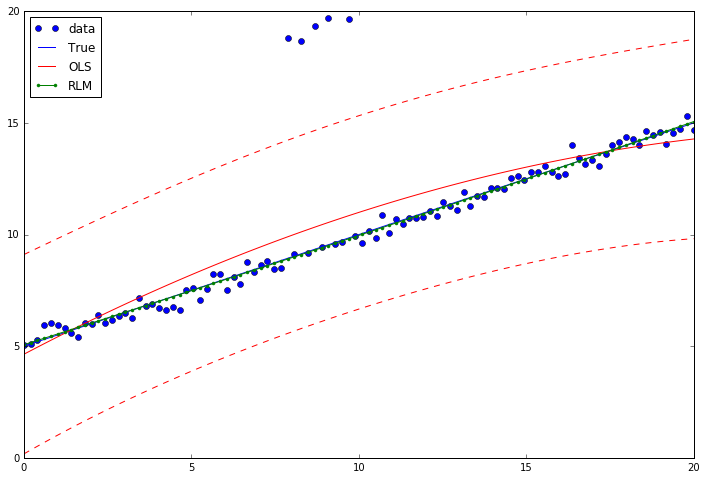

In [17]:
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
prstd, iv_l, iv_u = wls_prediction_std(results_ols)
ax.plot(x1, results_ols.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, results_rlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")

RLM was able to ignore the outliers and the model more accurately than the OLS model.

<a id='Multiple Linear Regression and ANOVA'></a>
## Example: Multiple Linear Regression and ANOVA

The dataset we are looking at is 'birthwt' (located also in the Rdatasets repository) , where we use:

 - mother's age (age)
 - mother's weight (lwt)
 - number of premature labors (ptl)
 - and number of physician visits during the first trimester (ftv)

We try to use these four predictor variables to predict the birth weight of a baby. The CMU course, 36-401: Modern Regression, also utilizes this dataset and does analysis in R. Here, we use StatsModels.

In [18]:
df = sm.datasets.get_rdataset("birthwt", "MASS").data
print df.head()
results = smf.ols('bwt~age+lwt+ptl+smoke', data=df).fit()
print results.summary()

    low  age  lwt  race  smoke  ptl  ht  ui  ftv   bwt
85    0   19  182     2      0    0   0   1    0  2523
86    0   33  155     3      0    0   0   0    3  2551
87    0   20  105     1      1    0   0   0    1  2557
88    0   21  108     1      1    0   0   1    2  2594
89    0   18  107     1      1    0   0   1    0  2600
                            OLS Regression Results                            
Dep. Variable:                    bwt   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4.068
Date:                Wed, 02 Nov 2016   Prob (F-statistic):            0.00348
Time:                        22:16:03   Log-Likelihood:                -1505.6
No. Observations:                 189   AIC:                             3021.
Df Residuals:                     184   BIC:                             3037.
Df Model:                           4 

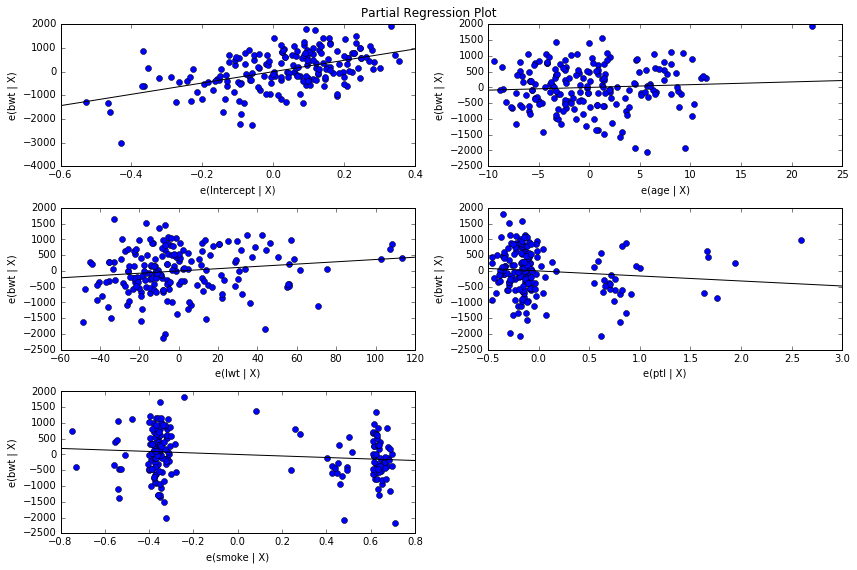

In [19]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results, fig=fig)

It looks like our first model is as follows:
predicted birthwt = 2395.52 + 8.74(age) + 3.62(lwt) - 159.28(ptl) - 239.45(smoke)

In [20]:
results.conf_int(alpha = .05)

,0,1
Intercept,1802.525628,2988.520659
age,-10.892098,28.374931
lwt,0.205544,7.048882
ptl,-372.239075,53.670608
smoke,-451.309073,-27.591924


In [21]:
sm.stats.anova_lm(results)

,df,sum_sq,mean_sq,F,PR(>F)
age,1.0,8.154832e+05,8.154832e+05,1.633697,0.202803
lwt,1.0,2.967339e+06,2.967339e+06,5.944612,0.015712
ptl,1.0,1.858527e+06,1.858527e+06,3.723276,0.055197
smoke,1.0,2.482053e+06,2.482053e+06,4.972415,0.026964
Residual,184.0,9.184625e+07,4.991644e+05,NaN,NaN


Similar to R, Statsmodels reports Sum of Squares based off the ordering of your predictor variables during modeling. Below are anova tables with different orderings. Notice that while the individual sum of squares are different, SSR (Residual Sum of squares) will always be the same.

In [22]:
results2 = smf.ols('bwt~lwt+smoke+ptl+age', data=df).fit()
results3 = smf.ols('bwt~smoke+age+ptl+lwt', data=df).fit()
print sm.stats.anova_lm(results2)
print sm.stats.anova_lm(results3)

             df        sum_sq       mean_sq         F    PR(>F)
lwt         1.0  3.448639e+06  3.448639e+06  6.908823  0.009302
smoke       1.0  3.326720e+06  3.326720e+06  6.664577  0.010613
ptl         1.0  9.628853e+05  9.628853e+05  1.928994  0.166547
age         1.0  3.851582e+05  3.851582e+05  0.771606  0.380866
Residual  184.0  9.184625e+07  4.991644e+05       NaN       NaN
             df        sum_sq       mean_sq         F    PR(>F)
smoke       1.0  3.625946e+06  3.625946e+06  7.264031  0.007687
age         1.0  6.714222e+05  6.714222e+05  1.345092  0.247641
ptl         1.0  1.642590e+06  1.642590e+06  3.290680  0.071303
lwt         1.0  2.183443e+06  2.183443e+06  4.374196  0.037860
Residual  184.0  9.184625e+07  4.991644e+05       NaN       NaN


So, should we include these variables?

Hypothesis testing for multivariate Regression is similar to single variable regression testing. We just have to be more careful about our calculations and the way we model the variables. Let's start off by testing individual coefficients.

If we want to test for:

Null: Estimator of ptl = 0

Alt: Estimator of ptl does not = 0

we must make sure we have `ptl` to be the last variable in our regression (since we are asking whether this variable should be included given the presence of all other variables). If you want to test a different individual coefficient, put that as the last variable.

While we can just call `f_stat`, below is manual way of calculating the f-statistic by indexing into the anova table.

In [23]:
results4 = smf.ols('bwt~age+lwt+smoke+ptl', data=df).fit()
SSR = sm.stats.anova_lm(results4).sum_sq['ptl']
df_onevar = sm.stats.anova_lm(results4).df['ptl']
SSE = sm.stats.anova_lm(results4).sum_sq['Residual']
df_all = sm.stats.anova_lm(results4).df['Residual']
f_stat = (SSR/df_onevar)/(SSE/df_all)
print f_stat

2.17770244261


In [24]:
#Same as from summary table
sm.stats.anova_lm(results).F['ptl']

3.7232759468674623

In [25]:
sp.stats.f.pdf(f_stat,df_onevar,df_all) #p-value

0.090920162066110352

Depending on our alpha level, we would reject at the 0.05 level but fail to reject at the 0.1 level. We may not want to include `ptl` in our model. 

This next test must be manually calculated as Statsmodels does not have a specific function to calculate it.

Null: Estimator of Smoke = Estimator of ptl = 0

Alt: At least one of these estimators does not = 0

In general, if you want to test a subset of estimators in the model, you must manually calculate it.

In [26]:
vars = ["smoke","ptl"]
SSR = 0
SSR_df = 0
for var in vars:
    SSR += sm.stats.anova_lm(results4).sum_sq[var]
    SSR_df += sm.stats.anova_lm(results4).df[var]
f_stat = (SSR/SSR_df)/(SSE/df_all)
print f_stat

4.34784563172


In [27]:
sp.stats.f.pdf(f_stat,SSR_df,df_all) #p-value

0.013644611866822033

We reject the null hypothesis at any reasonable alpha level and conclude that at least one of these estimators is not equal to 0.

<a id='Additional Resources'></a>
## Additional Resources

This tutorial only captures a tiny portion of StatsModels. Below is the link to the official documentation of StatsModels, the repository for all the R datasets, and additional information on statistical theory.

 - [StatsModels](http://statsmodels.sourceforge.net/devel/index.html)
 - [R Datasets](http://stat.ethz.ch/R-manual/R-devel/library/datasets/html/00Index.html)
 - [Linearity Assumptions](http://people.duke.edu/~rnau/testing.htm)
 - [Hypothesis Testing](http://www.cs.cmu.edu/~bhiksha/courses/10-601/hypothesistesting/hyptesting_practical.html)